# Red Light Intersection Crash Analysis

Linear regression analysis of factors affecting red light crashes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from modules.myfuncs import *
import warnings
import numpy as np
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import sqlite3
# import dask
# import dask.dataframe as dd
import gc

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 100

In [2]:
conn = create_connection('database/rlc2.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc2.db


In [3]:
print(sql_fetch_tables(c, conn))



def table_info(c, conn):
    '''
    prints out all of the columns of every table in db
    c : cursor object
    conn : database connection object
    '''
    tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    for table_name in tables:
        table_name = table_name[0]
        table = pd.read_sql_query("SELECT * from {} LIMIT 0".format(table_name), conn)
        print(table_name)
        for col in table.columns:
            print('\t-' + col)
        print()

table_info(c, conn)


[('intersection_chars',), ('cam_locations',), ('cam_startend',), ('daily_violations',), ('all_crashes',), ('hourly_congestion',), ('hourly_weather',), ('region_data',), ('intersection_cams',), ('signal_crashes',), ('all_hours',), ('int_startend',)]
intersection_chars
	-protected_turn
	-total_lanes
	-medians
	-exit
	-split
	-way
	-underpass
	-no_left
	-angled
	-triangle
	-one_way
	-turn_lanes
	-lat
	-long
	-rlc
	-intersection
	-daily_traffic

cam_locations
	-camera_id
	-intersection
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

cam_startend
	-camera_id
	-start
	-end

daily_violations
	-intersection
	-camera_id
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

all_crashes
	-crash_record_id
	-rd_no
	-crash_date
	-posted_speed_limit
	-traffic_control_device
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_def

## Query our data
I would like to get hourly intersection data with the following columns:


signal_crashes
	-crash_date
	-posted_speed_limit
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-most_severe_injury
	-injuries_total
	-injuries_fatal
	-injuries_incapacitating
	-injuries_non_incapacitating
	-injuries_reported_not_evident
	-injuries_no_indication
	-injuries_unknown
	-latitude
	-longitude
	-lane_cnt
	-work_zone_i
	-work_zone_type
	-workers_present_i
	-intersection
	-year
	-month
	-day
	-hour
	-region_id
	-time
	-weekday

hourly_weather
	-temp
	-rain_1h
	-rain_3h
	-snow_1h
	-snow_3h
	-time
	-year
	-month
	-day
	-hour
	-weekday

hourly_congestion
	-year
	-month
	-day
	-hour
	-region_id
	-bus_count
	-num_reads
	-speed
	-weekday
    
Tables will be queried to JOIN on year, month, day, hour

WHAT I REALLY NEED HERE
A single dataset with the following:
- daily intersection chars (all the stuff I entered)
- daily intersection crashes (injuries, deaths, number etc)
- daily wx (temp, precip mainly)
- daily congestion (might not need this)
- daily violations (already in the format)

In [14]:
# Try 5. All the same, but now I need to exclude before after start/end dates.  Need to bring back in days

# MY BIG DF
# This time, I will shoot for every intersection for every hour

# LINK daily_violations to hourly_congestion through intersection_cams with intersection_chars as well

crash_df = pd.read_sql_query('''WITH v AS(SELECT dv.intersection,
                                                SUM(dv.violations) as violations,
                                                (CASE
                                                    WHEN JulianDay(se.start) < JulianDay('2017-09-01 00:00:00') 
                                                        THEN CAST((JulianDay(se.end) - JulianDay('2017-09-01 00:00:00')) as Integer)
                                                    ELSE CAST((JulianDay(se.end) - JulianDay(se.start)) as Integer)
                                                END) as days_active,
                                                COUNT(DISTINCT dv.camera_id) as n_cams,
                                                start,
                                                end

                                            FROM daily_violations as dv
                                            LEFT JOIN int_startend as se
                                                ON se.intersection = dv.intersection
                                
                                            GROUP BY dv.intersection
                                            ), 
                                 
                                    ic AS(SELECT *
                                         FROM intersection_chars
                                         ),
                                         
                                   cr AS(SELECT *   
                                         FROM signal_crashes
                                         WHERE year > 2016 AND month > 8
                                        )
                                        
                                SELECT 
                                    (CAST(365 * SUM(cr.injuries_total) AS FLOAT) / v.days_active) as injuries_per_year,
                                    (CAST(365 * COUNT(cr.crash_record_id) AS FLOAT)/ v.days_active) as crash_per_year,
                                    ( (CAST(365 * COUNT(cr.crash_record_id) AS FLOAT)/ v.days_active) +
                                      (CAST(365 * SUM(cr.injuries_total) AS FLOAT) / v.days_active) +
                                      (CAST(365 * SUM(cr.injuries_incapacitating) AS FLOAT) / v.days_active)) AS danger_metric,
                                                        
                                    
                                    (CAST((ic.daily_traffic/ic.total_lanes)*0.001 AS FLOAT)) as traffic_density_k,
                                    (CAST(ic.daily_traffic*0.001 AS FLOAT)) as traffic_k,
                                    ic.protected_turn/ic.way as protected_ratio,

                                    (ic.exit + ic.split + ic.triangle + ic.angled + ic.one_way + ic.way-4) as complexity,
                                    
                                    ic.*,
                                    v.*,
                                    COUNT(crash_record_id) as n_crash,
                                    SUM(injuries_total) as injuries_total,
                                    SUM(injuries_fatal) as injuries_fatal,
                                    SUM(injuries_incapacitating) as injuries_incapacitating,
                                    SUM(injuries_non_incapacitating) as injuries_non_incapacitating,
                                    
                                    (CAST(ic.total_lanes AS FLOAT)/ic.way) AS lanes_per_direction
                                    
                                    

                                FROM v  
                                LEFT JOIN ic
                                    ON v.intersection = ic.intersection
                                LEFT JOIN cr
                                    ON cr.intersection = ic.intersection
                                WHERE cr.crash_date >= v.start AND cr.crash_date <= v.end
                                GROUP BY ic.intersection
                                ORDER BY ic.intersection
                                    ''', conn)


# 
# 
# v.start,
# v.end,
# CAST((JulianDay(v.end) - JulianDay(v.start)) as Integer) as delta_days

In [15]:


sql_fetch_tables(c, conn)

[('intersection_chars',),
 ('cam_locations',),
 ('cam_startend',),
 ('daily_violations',),
 ('all_crashes',),
 ('hourly_congestion',),
 ('hourly_weather',),
 ('region_data',),
 ('intersection_cams',),
 ('signal_crashes',),
 ('all_hours',),
 ('int_startend',)]

In [16]:
pd.options.display.max_columns = 100
len(crash_df)
crash_df.days_active.unique()
crash_df.head(50)

,injuries_per_year,crash_per_year,danger_metric,traffic_density_k,traffic_k,protected_ratio,complexity,protected_turn,total_lanes,medians,exit,split,way,underpass,no_left,angled,triangle,one_way,turn_lanes,lat,long,rlc,intersection,daily_traffic,intersection,violations,days_active,n_cams,start,end,n_crash,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,lanes_per_direction
0,3.543689,6.496764,10.335761,7.183,43.1,0,1,2,6,2,0,0,4,0,0,1,0,0,2,41.692362,-87.642423,1,111TH AND HALSTED,43100,111TH AND HALSTED,22081,1236,2,2016-01-02 00:00:00,2021-01-19 00:00:00,22,12,0,1,6,1.50
1,0.000000,6.636364,6.636364,7.083,42.5,1,0,4,6,2,0,0,4,0,0,0,0,0,4,41.685089,-87.642094,1,115TH AND HALSTED,42500,115TH AND HALSTED,10270,55,2,2016-01-02 00:00:00,2017-10-26 00:00:00,1,0,0,0,0,1.50
2,2.953074,5.315534,8.563916,6.966,41.8,1,0,4,6,2,0,0,4,0,0,0,0,0,4,41.677774,-87.641930,1,119TH AND HALSTED,41800,119TH AND HALSTED,20484,1236,2,2016-01-02 00:00:00,2021-01-19 00:00:00,18,10,0,1,7,1.50
3,1.771845,5.315534,7.087379,3.650,36.5,0,1,2,10,2,0,1,4,0,2,0,0,0,0,41.838441,-87.617338,1,31ST ST AND MARTIN LUTHER KING DRIVE,36500,31ST ST AND MARTIN LUTHER KING DRIVE,26144,1236,2,2016-01-02 00:00:00,2021-01-19 00:00:00,18,6,0,0,4,2.50
4,1.181230,6.792071,7.973301,5.300,42.4,0,1,2,8,2,0,1,4,0,0,0,0,0,2,41.830281,-87.684775,1,35TH AND WESTERN,42400,35TH AND WESTERN,10980,1236,2,2016-01-02 00:00:00,2021-01-19 00:00:00,23,4,0,0,3,2.00
5,4.724919,15.355987,20.376214,4.900,58.8,0,1,3,12,2,0,1,4,0,0,0,0,0,2,41.808442,-87.684183,1,4700 WESTERN,58800,4700 WESTERN,12244,1236,2,2016-01-02 00:00:00,2021-01-19 00:00:00,52,16,0,1,7,3.00
6,0.295307,2.362460,2.657767,12.275,49.1,1,0,4,4,0,0,0,4,0,0,0,0,0,4,41.793497,-87.703592,1,55TH AND KEDZIE,49100,55TH AND KEDZIE,6883,1236,2,2016-01-02 00:00:00,2021-01-19 00:00:00,8,1,0,0,1,1.00
7,0.000000,5.315534,5.315534,4.890,48.9,0,2,4,10,0,0,0,5,0,0,0,0,1,4,41.793862,-87.684029,1,55TH AND WESTERN,48900,55TH AND WESTERN,15949,1236,2,2016-01-02 00:00:00,2021-01-19 00:00:00,18,0,0,0,0,2.00
8,0.590615,5.610841,6.201456,10.462,83.7,1,0,4,8,0,0,0,4,0,0,0,0,0,4,41.793208,-87.723199,1,55TH and PULASKI,83700,55TH and PULASKI,7562,1236,2,2016-01-02 00:00:00,2021-01-19 00:00:00,19,2,0,0,1,2.00
9,0.590615,2.953074,3.543689,5.466,32.8,0,0,2,6,2,0,0,4,2,3,0,0,0,2,41.780357,-87.624863,1,63RD AND STATE,32800,63RD AND STATE,31536,1236,2,2016-01-02 00:00:00,2021-01-19 00:00:00,10,2,0,0,2,1.50


This is a massive dataframe when using hours. We have an intersection row for every


In [1710]:
crash_df.drop_duplicates(inplace=True)
crash_df = crash_df.loc[:,~crash_df.columns.duplicated()]  # had a dupe column preventing modeling


In [1711]:
# need to drop all of the rows I don't have data for
try:
    crash_df.dropna(subset=['crash_record_id'], inplace=True)
except Exception as e:
    print(e)

['crash_record_id']


In [1712]:
# now drop out the rows that do not have daily violations. Should cure all our nans
# Some of these cams were only running before our query.
crash_df.dropna(subset=['violations'], inplace=True)

In [1713]:
# approximate number of entries is 1.6M
print('Total days:', 365.25 * 5)

# approximate number of entries is 1.6M
print('Total month entries:', 12 * 5 * 159)

# additional entries may occur for double accidents
# fewer entries for inactive cameras
print('Est. Total day entries:', 365 * 159 * 5) # 5 years and 183 intersections for now


print()
crash_df.info()
len(crash_df.intersection.unique())

Total days: 1826.25
Total month entries: 9540
Est. Total day entries: 290175

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 0 to 151
Data columns (total 36 columns):
injuries_per_year              152 non-null float64
crash_per_year                 152 non-null float64
danger_metric                  152 non-null float64
traffic_density_k              152 non-null float64
traffic_k                      152 non-null float64
protected_ratio                152 non-null int64
complexity                     152 non-null int64
protected_turn                 152 non-null int64
total_lanes                    152 non-null int64
medians                        152 non-null int64
exit                           152 non-null int64
split                          152 non-null int64
way                            152 non-null int64
underpass                      152 non-null int64
no_left                        152 non-null int64
angled                         152 non-null int64
triangl

152

##### pd.options.display.max_columns = 100
#crash_df.head(100)
crash_df.isna().sum()


In [1714]:
crash_df[crash_df.n_crash.isna()]  # missing two intersections. HUH!!!

# First one is at the Home Depot towards Lincolnwood.  That's a crazy intersection. 
# I will drop it for now, but would like to go back ans see what happened here.
crash_df.dropna(subset=['intersection'], inplace=True)

In [1715]:
crash_df.isna().sum()

injuries_per_year              0
crash_per_year                 0
danger_metric                  0
traffic_density_k              0
traffic_k                      0
protected_ratio                0
complexity                     0
protected_turn                 0
total_lanes                    0
medians                        0
exit                           0
split                          0
way                            0
underpass                      0
no_left                        0
angled                         0
triangle                       0
one_way                        0
turn_lanes                     0
lat                            0
long                           0
rlc                            0
intersection                   0
daily_traffic                  0
violations                     0
days_active                    0
n_cams                         0
start                          0
end                            0
n_crash                        0
injuries_t

In [1716]:
crash_df.info()  # All good!!

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 0 to 151
Data columns (total 36 columns):
injuries_per_year              152 non-null float64
crash_per_year                 152 non-null float64
danger_metric                  152 non-null float64
traffic_density_k              152 non-null float64
traffic_k                      152 non-null float64
protected_ratio                152 non-null int64
complexity                     152 non-null int64
protected_turn                 152 non-null int64
total_lanes                    152 non-null int64
medians                        152 non-null int64
exit                           152 non-null int64
split                          152 non-null int64
way                            152 non-null int64
underpass                      152 non-null int64
no_left                        152 non-null int64
angled                         152 non-null int64
triangle                       152 non-null int64
one_way                        152 

In [1717]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 500

#crash_df.groupby(['year', 'month', 'day', 'hour']).count().reset_index().head(500)  # REGIONS!!!!!!

# look at a single day of data
# crash_df[(crash_df['year']==2016) &
#          (crash_df['month']==6) &
#          (crash_df['day']==1)
#         ].describe()

In [1718]:
crash_df.describe()

,injuries_per_year,crash_per_year,danger_metric,traffic_density_k,traffic_k,protected_ratio,complexity,protected_turn,total_lanes,medians,exit,split,way,underpass,no_left,angled,triangle,one_way,turn_lanes,lat,long,rlc,daily_traffic,violations,days_active,n_cams,n_crash,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,lanes_per_direction,traffic_squared
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.0,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.0,152.000000,152.000000,152.000000,1.520000e+02
mean,1.842460,4.668885,6.719562,8.065230,50.988158,0.342105,0.815789,2.171053,6.572368,0.427632,0.118421,0.046053,4.111842,0.131579,0.250000,0.151316,0.177632,0.210526,3.269737,41.883567,-87.699093,1.0,50988.157895,21296.467105,1197.513158,2.006579,15.250000,6.125000,0.0,0.690789,3.605263,1.309211,2.804509e+09
std,1.611708,2.893151,4.198262,2.211113,14.355219,0.475983,1.329348,1.606181,1.825507,0.777174,0.324174,0.210292,0.468184,0.441013,0.632979,0.359541,0.383466,0.571180,1.291697,0.083616,0.050982,0.0,14355.218883,20045.504436,134.429675,0.244047,9.769699,5.362752,0.0,1.024427,3.652375,0.491431,1.676486e+09
min,0.000000,0.299918,0.599836,3.011000,21.600000,0.000000,-1.000000,0.000000,4.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.677774,-87.812226,1.0,21600.000000,1461.000000,55.000000,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,1.000000,4.665600e+08
25%,0.599836,2.699260,3.898932,6.574750,42.025000,0.000000,0.000000,1.000000,6.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,41.814673,-87.740803,1.0,42025.000000,10080.000000,1217.000000,2.000000,9.000000,2.000000,0.0,0.000000,1.000000,1.000000,1.766118e+09
50%,1.499589,4.198850,6.298274,8.062500,49.200000,0.000000,0.000000,2.000000,6.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,41.906625,-87.699521,1.0,49200.000000,15060.500000,1217.000000,2.000000,14.000000,5.000000,0.0,0.000000,3.000000,1.000000,2.420640e+09
75%,2.402315,5.998357,8.397699,9.650000,58.050000,1.000000,1.000000,4.000000,8.000000,1.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,41.946248,-87.662591,1.0,58050.000000,21863.250000,1217.000000,2.000000,20.000000,8.000000,0.0,1.000000,5.000000,2.000000,3.369810e+09
max,10.197206,23.993426,35.390304,13.925000,105.500000,1.000000,8.000000,4.000000,14.000000,3.000000,1.000000,1.000000,6.000000,2.000000,3.000000,1.000000,1.000000,3.000000,6.000000,42.012234,-87.575373,1.0,105500.000000,129945.000000,1217.000000,3.000000,80.000000,34.000000,0.0,5.000000,23.000000,3.000000,1.113025e+10


Now we have a pretty solid dataframe to do analysis on the red light intersections.

We would like to know what factors affect the target (danger)

In [1719]:
crash_df = crash_df.loc[:,~crash_df.columns.duplicated()]  # had a dupe column preventing modeling

crash_df.columns

df_final = crash_df.copy()

## Single variable regression

In [1720]:
# Lets look at some regressions for all of my chosen columns

# import libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms

# I don't need to see regression analysis for all of my variables
target = 'danger_metric'

continuous = [target, 'traffic_k', 'protected_ratio', 'complexity', 'total_lanes', 'traffic_squared',
              'traffic_density_k', 'lanes_per_direction', 'n_cams', 'medians', 'way', 'turn_lanes', 'protected_ratio']

categoricals = ['exit', 'split', 'underpass', 'angled', 'triangle', 'rlc', 
                 'no_left', 'one_way']

df_cont = df_final[continuous]



results = []

for idx, column in enumerate(df_cont.columns):
    print()
    print((column.upper() + " **** ") * 5)
    print ("Red Light Camera Crash - Injuries")
    
    f = '{}~{}'.format(target, column)  # create my model formula
    model = smf.ols(formula=f, data=df_cont).fit()  # fit the model
    print(model.summary())
    
#     fig, axes = plt.subplots(figsize=(15,12))
#     fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
#     fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
#     fig.tight_layout()
#     plt.show()
    
    results.append([column, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0]])

result_df = pd.DataFrame(results, columns=['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)' ])
result_df.sort_values(by='r_squared')


DANGER_METRIC **** DANGER_METRIC **** DANGER_METRIC **** DANGER_METRIC **** DANGER_METRIC **** 
Red Light Camera Crash - Injuries
                            OLS Regression Results                            
Dep. Variable:          danger_metric   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.731e+33
Date:                Mon, 01 Feb 2021   Prob (F-statistic):               0.00
Time:                        13:50:36   Log-Likelihood:                 5002.5
No. Observations:                 152   AIC:                        -1.000e+04
Df Residuals:                     150   BIC:                            -9995.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.97

,ind_var,r_squared,intercept,slope,p-value,normality (JB)
11,turn_lanes,0.000055,6.640945e+00,2.404389e-02,9.279271e-01,1334.764753
2,protected_ratio,0.003193,6.890063e+00,-2.491940e-01,4.892850e-01,1276.108527
12,protected_ratio,0.003193,6.890063e+00,-2.491940e-01,4.892850e-01,1276.108527
6,traffic_density_k,0.015043,8.597757e+00,-2.328756e-01,1.322392e-01,1327.065972
9,medians,0.030428,6.316605e+00,9.423001e-01,3.160627e-02,1624.270102
10,way,0.034774,-1.561026e-01,1.672162e+00,2.143227e-02,620.961753
1,traffic_k,0.096416,2.089329e+00,9.080998e-02,9.889412e-05,521.525350
7,lanes_per_direction,0.096426,3.246491e+00,2.652798e+00,9.880579e-05,1103.881971
3,complexity,0.099844,5.905477e+00,9.979109e-01,7.320951e-05,201.033831
5,traffic_squared,0.132719,4.161021e+00,9.122957e-10,3.950841e-06,287.470432


In [1721]:
#scatter plot takes a few min

# pd.plotting.scatter_matrix(df_cont,figsize  = [20, 20]);
# plt.show()

In [1722]:
df_cont.corr()  # create a correlation matrix

,danger_metric,traffic_k,protected_ratio,complexity,total_lanes,traffic_squared,traffic_density_k,lanes_per_direction,n_cams,medians,way,turn_lanes,protected_ratio
danger_metric,1.000000,0.310509,-0.056505,0.315981,0.439367,0.364306,-0.122649,0.310525,0.383375,0.174437,0.186477,0.007398,-0.056505
traffic_k,0.310509,1.000000,0.292235,0.185202,0.484410,0.978456,0.464074,0.308339,0.104369,0.071570,0.293640,0.284645,0.292235
protected_ratio,-0.056505,0.292235,1.000000,-0.360261,-0.005817,0.253349,0.312188,0.054389,-0.076515,-0.219070,-0.172832,0.387486,1.000000
complexity,0.315981,0.185202,-0.360261,1.000000,0.461270,0.230046,-0.262120,0.189141,0.167066,0.204955,0.693041,-0.121285,-0.360261
total_lanes,0.439367,0.484410,-0.005817,0.461270,1.000000,0.507955,-0.504068,0.775844,0.021222,0.339804,0.265542,-0.054674,-0.005817
traffic_squared,0.364306,0.978456,0.253349,0.230046,0.507955,1.000000,0.402959,0.332938,0.139085,0.078247,0.286393,0.222152,0.253349
traffic_density_k,-0.122649,0.464074,0.312188,-0.262120,-0.504068,0.402959,1.000000,-0.401119,0.050254,-0.275253,0.028379,0.331970,0.312188
lanes_per_direction,0.310525,0.308339,0.054389,0.189141,0.775844,0.332938,-0.401119,1.000000,-0.072293,0.327744,-0.093736,-0.132263,0.054389
n_cams,0.383375,0.104369,-0.076515,0.167066,0.021222,0.139085,0.050254,-0.072293,1.000000,0.089818,0.225360,0.057358,-0.076515
medians,0.174437,0.071570,-0.219070,0.204955,0.339804,0.078247,-0.275253,0.327744,0.089818,1.000000,-0.023110,-0.320170,-0.219070


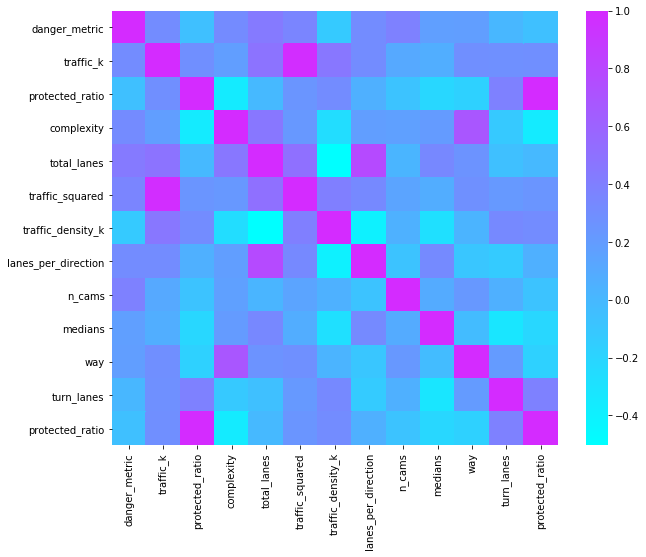

In [1723]:
import seaborn as sns

plt.figure(figsize = (10,8))
sns.heatmap(df_cont.corr(), center=0.4, cmap = "cool");

# One Hot Encoding

In [1724]:
crash_df.columns

Index(['injuries_per_year', 'crash_per_year', 'danger_metric',
       'traffic_density_k', 'traffic_k', 'protected_ratio', 'complexity',
       'protected_turn', 'total_lanes', 'medians', 'exit', 'split', 'way',
       'underpass', 'no_left', 'angled', 'triangle', 'one_way', 'turn_lanes',
       'lat', 'long', 'rlc', 'intersection', 'daily_traffic', 'violations',
       'days_active', 'n_cams', 'start', 'end', 'n_crash', 'injuries_total',
       'injuries_fatal', 'injuries_incapacitating',
       'injuries_non_incapacitating', 'lanes_per_direction',
       'traffic_squared'],
      dtype='object')

In [1725]:
# get rid of categories that have high correlation and others.

df_continuous = df_cont.copy()
#df_ohe = crash_df[categoricals] # defined earlier
df_ohe = df_final[categoricals] # defined earlier

# One hot encoding   
#df_ohe = pd.get_dummies(df_ohe, columns=['way'], drop_first=True)
df_final = pd.concat([df_continuous, df_ohe], axis=1)

In [1726]:
#df_final = df_final.drop(columns=['traffic_density_k', 'protected_turn', 'medians', 'violations', 'n_crash', 'exit', 'split', 'underpass', 'angled', 'triangle', 'rlc', 'n_cams'])

In [1727]:
pd.options.display.max_columns = 100
df_final.head()

,danger_metric,traffic_k,protected_ratio,complexity,total_lanes,traffic_squared,traffic_density_k,lanes_per_direction,n_cams,medians,way,turn_lanes,protected_ratio,exit,split,underpass,angled,triangle,rlc,no_left,one_way
0,9.597371,43.1,0,1,6,1857610000,7.183,1,2,2,4,2,0,0,0,0,1,0,1,0,0
1,6.636364,42.5,1,0,6,1806250000,7.083,1,2,2,4,4,1,0,0,0,0,0,1,0,0
2,8.697617,41.8,1,0,6,1747240000,6.966,1,2,2,4,4,1,0,0,0,0,0,1,0,0
3,7.198028,36.5,0,1,10,1332250000,3.650,2,2,2,4,0,0,0,1,0,0,0,1,2,0
4,8.097781,42.4,0,1,8,1797760000,5.300,2,2,2,4,2,0,0,1,0,0,0,1,0,0


## Feature selection

In [1728]:
target = 'danger_metric'

X_ = df_final.drop(target, axis=1)  # drop my potential targets

y = df_final[target]

In [1729]:
### FEATURE SELECTION

#from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg)
selector = selector.fit(X_, y)
print(selector.support_)
print(X_.columns)

[False False  True  True False False False  True False  True False False
  True  True False  True  True False  True  True]
Index(['traffic_k', 'protected_ratio', 'complexity', 'total_lanes',
       'traffic_squared', 'traffic_density_k', 'lanes_per_direction', 'n_cams',
       'medians', 'way', 'turn_lanes', 'protected_ratio', 'exit', 'split',
       'underpass', 'angled', 'triangle', 'rlc', 'no_left', 'one_way'],
      dtype='object')


In [1730]:
selector.support_ 
print('Feature Selection')
selected_features = []
print('{:>20} {:^8} {:^8} {:^8}'.format('FEATURE', 'RANK', 'SELECT', 'COEFFICIENT'))


#print(selector.estimator_.coef_)
step = 0

for i in range(len(X_.columns)):
    rank = selector.ranking_[i]
    select = selector.support_[i]
    col = X_.columns[i]
   
    if select: 
        coef = selector.estimator_.coef_[step]
        step+=1
        selected_features.append([col, rank])
    else:
        coef = 0
    
    print('{:>20} {:^8} {:^10} {:^5.4f}'.format(col, rank, bool(select), coef))
        
intercept = selector.estimator_.intercept_
print('\nIntercept:', intercept)


Feature Selection
             FEATURE   RANK    SELECT  COEFFICIENT
           traffic_k    9         0      0.0000
     protected_ratio    5         0      0.0000
          complexity    1         1      1.0901
         total_lanes    1         1      0.7271
     traffic_squared    10        0      0.0000
   traffic_density_k    6         0      0.0000
 lanes_per_direction    2         0      0.0000
              n_cams    1         1      5.2349
             medians    4         0      0.0000
                 way    1         1      -1.0514
          turn_lanes    7         0      0.0000
     protected_ratio    8         0      0.0000
                exit    1         1      1.5144
               split    1         1      3.7435
           underpass    3         0      0.0000
              angled    1         1      -0.8878
            triangle    1         1      -0.5414
                 rlc    11        0      0.0000
             no_left    1         1      -0.6298
             on

In [1731]:
selected_features.sort(key=lambda x: x[1])
selected_features

[['complexity', 1],
 ['total_lanes', 1],
 ['n_cams', 1],
 ['way', 1],
 ['exit', 1],
 ['split', 1],
 ['angled', 1],
 ['triangle', 1],
 ['no_left', 1],
 ['one_way', 1]]

In [1732]:
selector.ranking_
estimators = selector.estimator_
print()
print(estimators.coef_)
print()
print(estimators.intercept_)


[ 1.09009194  0.7271379   5.2348955  -1.05141105  1.51436755  3.74348633
 -0.88775745 -0.54143883 -0.62981301 -1.68715461]

-4.738314892916843


In [1733]:
df_final.head()

,danger_metric,traffic_k,protected_ratio,complexity,total_lanes,traffic_squared,traffic_density_k,lanes_per_direction,n_cams,medians,way,turn_lanes,protected_ratio,exit,split,underpass,angled,triangle,rlc,no_left,one_way
0,9.597371,43.1,0,1,6,1857610000,7.183,1,2,2,4,2,0,0,0,0,1,0,1,0,0
1,6.636364,42.5,1,0,6,1806250000,7.083,1,2,2,4,4,1,0,0,0,0,0,1,0,0
2,8.697617,41.8,1,0,6,1747240000,6.966,1,2,2,4,4,1,0,0,0,0,0,1,0,0
3,7.198028,36.5,0,1,10,1332250000,3.650,2,2,2,4,0,0,0,1,0,0,0,1,2,0
4,8.097781,42.4,0,1,8,1797760000,5.300,2,2,2,4,2,0,0,1,0,0,0,1,0,0


## Apply my feature selection to data

In [1734]:
selector.support_
selector.support_[0]=True

In [1735]:
X_ = X_.iloc[:,selector.support_] # force support of traffic

In [1736]:
print(X_.columns)
print(selector.support_)
X = X_
# this did not result in a positive r2 value.  I will manually select some of my features instead

Index(['traffic_k', 'complexity', 'total_lanes', 'n_cams', 'way', 'exit',
       'split', 'angled', 'triangle', 'no_left', 'one_way'],
      dtype='object')
[ True False  True  True False False False  True False  True False False
  True  True False  True  True False  True  True]


### Manual Feature selection

In [1691]:
df_final.columns

Index(['danger_metric', 'traffic_k', 'protected_ratio', 'complexity',
       'total_lanes', 'traffic_density_k', 'lanes_per_direction', 'n_cams',
       'medians', 'way', 'turn_lanes', 'protected_ratio', 'exit', 'split',
       'underpass', 'angled', 'triangle', 'rlc', 'no_left', 'one_way'],
      dtype='object')

In [1692]:
# [['protected_ratio', 1],
#  ['complexity', 1],
#  ['total_lanes', 1],
#  ['exit', 1],
#  ['split', 1],
#  ['n_cams', 1],
#  ['no_left', 1],
#  ['one_way', 1],
#  ['protected_turn', 1]]

keepers = ['traffic_k', 'underpass', 'protected_ratio', 'triangle','exit', 'split', 'n_cams', 'no_left', 'total_lanes']
X = X_[keepers]

KeyError: "['traffic_k', 'protected_ratio', 'triangle', 'underpass'] not in index"

# Linear Regression

In [1737]:
# Import statsmodels.api as sm
from statsmodels.formula.api import ols

In [1738]:
pred_sum = '+'.join(X.columns)
formula = target + '~' + pred_sum

In [1739]:
model = ols(formula=formula, data=pd.concat([X, y], axis=1)).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          danger_metric   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     10.11
Date:                Mon, 01 Feb 2021   Prob (F-statistic):           1.10e-12
Time:                        13:51:42   Log-Likelihood:                -392.17
No. Observations:                 152   AIC:                             806.3
Df Residuals:                     141   BIC:                             839.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.2167      1.152     -1.056      0.293      -3.494       1.061
traffic_k       0.0372      0.023      1.628      0.106      -0.008       0.082
complexity      1.8480      0.568      3.252      0.001       0.725       2.971
total_lanes     0.5586      0.212      2.632      0.009       0.139       0.978
n_cams          5.0877      1.212      4.196      0.000       2.691       7.485
way            -2.0726      0.582     -3.562      0.001      -3.223      -0.922
exit            0.7995      1.174      0.681      0.497      -1.522       3.121
split           3.2707      1.673      1.955      0.053      -0.037       6.578
angled         -1.6192      1.180     -1.372      0.172      -3.952       0.714
triangle       -1.1357      1.121     -1.013      0.313      -3.351       1.080
no_left        -0.5957      0.469     -1.271      0.206      -1.522       0.331
one_way        -2.2616      0.875     -2.584      0.011      -3.992      -0.531
==============================================================================
Omnibus:                       13.534   Durbin-Watson:                   2.211
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.341
Skew:                           0.623   Prob(JB):                     0.000466
Kurtosis:                       3.933   Cond. No.                     6.60e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is  1e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [1740]:
#from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression


reg = LinearRegression(fit_intercept=False).fit(X, y)  # my regression object


# Good time to do a baseline r_squared calculation
crossvalidation = KFold(n_splits=5, shuffle=True, random_state=42)
baseline = cross_val_score(reg, X, y, scoring='r2', cv=crossvalidation)

# Do the actual regression
coefficients = dict(zip(X.columns,list(reg.coef_)))
for var in coefficients:
    print('{:>12}: {}'.format(var, coefficients[var]))

print()
print(baseline)
print('Baseline r_squared val:', np.mean(baseline))

   traffic_k: 0.03720757466626106
  complexity: 2.152226138965787
 total_lanes: 0.558605333784204
      n_cams: 5.087714828717939
         way: -2.3767859665975606
        exit: 0.4953125462058234
       split: 2.9665042249555706
      angled: -1.9234048361991707
    triangle: -1.4398708344159243
     no_left: -0.5957196125457538
     one_way: -2.565820691096436

[-0.10898656  0.17982685  0.26826376  0.53858097 -0.19331812]
Baseline r_squared val: 0.13687338098687712


In [1741]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

mse = make_scorer(mean_squared_error)
cv_5_results = cross_val_score(reg, X, y, cv=5, scoring='r2')



In [1742]:
np.mean(cv_5_results)


0.06315136598324848

I need more information about the intersection other than just names.
I need descriptive info, but it isn't available in violations table.  Crash data does have some stuff though

In [1743]:
# would like to use ridge because I seem to have some correlated data

from sklearn.linear_model import Ridge
import numpy as np

clf = Ridge(alpha=1.0, fit_intercept=False)
clf.fit(X, y)


Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [1744]:
#from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression

# Good time to do a baseline r_squared calculation
crossvalidation = KFold(n_splits=5, shuffle=True, random_state=42)
baseline = cross_val_score(clf, X, y, scoring='r2', cv=crossvalidation)

# Do the actual regression
coefficients = dict(zip(X.columns,list(reg.coef_)))
for var in coefficients:
    print('{:>12}: {}'.format(var, coefficients[var]))

print()
print(baseline)
print('Baseline r_squared val:', np.mean(baseline))

   traffic_k: 0.03720757466626106
  complexity: 2.152226138965787
 total_lanes: 0.558605333784204
      n_cams: 5.087714828717939
         way: -2.3767859665975606
        exit: 0.4953125462058234
       split: 2.9665042249555706
      angled: -1.9234048361991707
    triangle: -1.4398708344159243
     no_left: -0.5957196125457538
     one_way: -2.565820691096436

[ 0.03091981  0.16265447  0.2558759   0.51574047 -0.18993237]
Baseline r_squared val: 0.15505165829886264


In [1745]:
danger_avg = y.quantile(0.9)
bin_y = y.apply(lambda x: 1 if x > danger_avg else 0)

In [1746]:

from sklearn.ensemble import RandomForestClassifier


# X = df_final.drop(columns=[target]).values
# y = df_final[target].values

# define random forest classifier
forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)


In [1747]:
forest.fit(X, bin_y) # need to do an int to classify it or bin it

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [1748]:
y.shape
X.shape
X.columns


Index(['traffic_k', 'complexity', 'total_lanes', 'n_cams', 'way', 'exit',
       'split', 'angled', 'triangle', 'no_left', 'one_way'],
      dtype='object')

In [1749]:
from boruta import BorutaPy

forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
forest.fit(X.values, bin_y.values)

# define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=1, random_state=1)

# find all relevant features
feat_selector.fit(X.values, bin_y.values)

# check selected features
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

TypeError: '(slice(None, None, None), array([False, False,  True, False, False, False, False, False, False,
       False, False]))' is an invalid key

In [1750]:

# zip my names, ranks, and decisions in a single iterable
feature_ranks = list(zip(df_final.columns, 
                         feat_selector.ranking_, 
                         feat_selector.support_))

# iterate through and print out the results
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

Feature: danger_metric             Rank: 2,  Keep: False
Feature: traffic_k                 Rank: 3,  Keep: False
Feature: protected_ratio           Rank: 1,  Keep: True
Feature: complexity                Rank: 5,  Keep: False
Feature: total_lanes               Rank: 10,  Keep: False
Feature: traffic_squared           Rank: 4,  Keep: False
Feature: traffic_density_k         Rank: 6,  Keep: False
Feature: lanes_per_direction       Rank: 9,  Keep: False
Feature: n_cams                    Rank: 11,  Keep: False
Feature: medians                   Rank: 8,  Keep: False
Feature: way                       Rank: 6,  Keep: False


In [1751]:
# camera




int_df = pd.read_sql_query('''
                                    WITH v as
                                        (SELECT intersection,
                                                violations,
                                                month,
                                                dat as day,
                                                weekday,
                                                year
                                        FROM daily_violations
                                        GROUP BY intersection
                                        ),
                                    cr as
                                        (SELECT intersection,
                                                COUNT(crash_record_id) as n_crash,
                                                SUM(injuries_total) as injuries,
                                                SUM(injuries_fatal) as deaths
                                         FROM signal_crashes
                                         GROUP BY intersection
                                         ORDER BY intersection
                                         )
                                    SELECT v.intersection, v.violations, cr.n_crash, cr.injuries, cr.deaths
                                    FROM v
                                    LEFT JOIN cr
                                        ON cr.intersection=v.intersection
                                    GROUP BY v.intersection
                                         
                                    ''', conn)

DatabaseError: Execution failed on sql '
                                    WITH v as
                                        (SELECT intersection,
                                                violations,
                                                month,
                                                dat as day,
                                                weekday,
                                                year
                                        FROM daily_violations
                                        GROUP BY intersection
                                        ),
                                    cr as
                                        (SELECT intersection,
                                                COUNT(crash_record_id) as n_crash,
                                                SUM(injuries_total) as injuries,
                                                SUM(injuries_fatal) as deaths
                                         FROM signal_crashes
                                         GROUP BY intersection
                                         ORDER BY intersection
                                         )
                                    SELECT v.intersection, v.violations, cr.n_crash, cr.injuries, cr.deaths
                                    FROM v
                                    LEFT JOIN cr
                                        ON cr.intersection=v.intersection
                                    GROUP BY v.intersection
                                         
                                    ': no such column: dat